## Introduction and Description of Data


This morning’s (07 December 2017) Daily Mail reports that Rate of Alzheimer's disease will more than DOUBLE in America by 2060, based on a study by UCLA. a This means 3.8 million Americans may have Alzheimer’s disease, at a cost of $1.1 trillion per year. Contrast this state with the fact that the diagnosis of Alzheimer’s is still not a sure science; there is a horde of diagnostic tests, none of which can identify with confidence.

Our data is obatained from the **Alzheimer’s Disease Neuroimaging Initiative (ADNI)**. It consists of the diagnosis of various patients (with their demographic information) who were tested for AD over different periods of time, using three testing protocols - ADNI1, ADNI GO and ADNI2. 
<br/> <br/>

**EDA Overview**

We began by conducting basic EDA and asking questions on the basis of the various Alzheimer’s Detection tests available. It was our understanding, corroborated by a conversation with our TF, that the contemporary testing mechanisms are ambiguous at best and a confirmatory diagnosis or AD/No AD can only be provided by conducting an invasive, usually post-mortem analysis. Therefore, we decided that the ultimate goal of the project could be to create a combined metric/test which could predict Alzheimer’s with a higher confidence rate than individual tests. Some of the preliminary questions, then, were:

1. Which of the tests(MMSE, RAVLT, FAQ) are correlated?
2. Based on our study of these individual tests, what are the inherent biases in the tests that may skew the diagnosis? (For instance, MMSE tends to get biased by the education status of the patients)
3. Do any individual tests directly correlate with the degeneration of a specific area of the brain?
4. What are the general trends with the demographic data? Specifically: 
  * Does marital/educational status make a difference?
  * Is there a site based bias that may speak to the “diversity” of the patient’s area of residence?
  * We read some anecdotal articles on the correlation of diet to Alzheimer’s. Assuming ethnicity as a proxy for diet, does ethnicity make a difference in the baseline diagnosis? 
5. Since the data is longitudinal, what scores actually change over time and different tests?
6. Is there a reason that the tests are conducted at the frequency they are?
meta -test
7. Confidence

<br/> <br/>

**Insight from Data and Methods Used**

Through preliminary EDA, we realised that the need to deal with longitudinal data. We thought that to deal with this data, we would need to see how the different test scores varied for the same patients over time, especially for patients with the maximum count of diagnosis over time. For most tests, the values were pretty static and we decided to use the last test score. The next issue was dealing with Nans. There were some puzzling instances of Nans (for instance, DX is Nan when DX_baseline is not or vice versa), so for preliminary EDA we decided to drop those values. However, in the future we can use classification based on correlated parameters to impute values for NaNs.

At the end, we got a sense of which tests, demographics and markers are correlated. It also helped us gauge the complexity of dealing with longitudinal data. Post-EDA, we also began to understand the need of a better combined classifier, and the difficulty of classifying the ‘MCI’ class where there is maximum ‘bleeding in’ from other categories.
<br/> <br/>

## Visualizations

<br/>
#### 1. Which of the tests (MMSE, RAVLT, FAQ) are correlated?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [2]:
data = pd.read_csv("ADNIMERGE.csv")
cols = ['PTID', 'RID', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE',
       'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'ADAS11','ADAS13','FAQ','MMSE','RAVLT_immediate',
       'RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting',
       'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl', 
       'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 
       'RAVLT_perc_forgetting_bl', 'Years_bl', 'Month_bl']
        
subset = data[cols]

# Removing null values
by_RID = subset.sort_values(["RID","EXAMDATE"])
by_RID = by_RID.reset_index(drop=True)
by_RID = by_RID.dropna()

# Considering only one set of data for each patient
no_long = by_RID.groupby(by='RID').last()
no_long.shape

# masks
ad = no_long[no_long['DX_bl'] == 'AD']
cn = no_long[no_long['DX_bl'] == 'CN']
emci = no_long[no_long['DX_bl'] == 'EMCI']
lmci = no_long[no_long['DX_bl'] == 'LMCI']
smc = no_long[no_long['DX_bl'] == 'SMC']

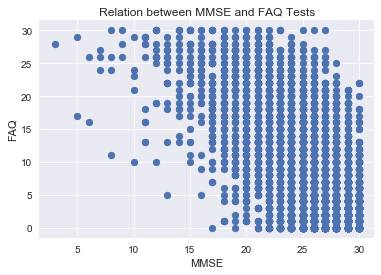

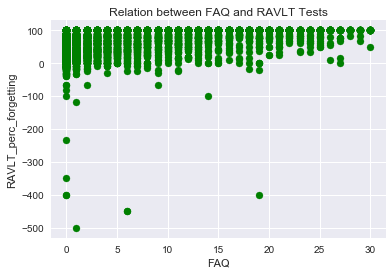

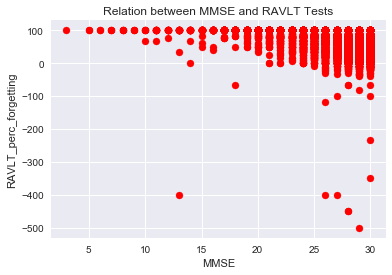

In [3]:
plt.scatter(by_RID['MMSE'],by_RID['FAQ'])
plt.xlabel('MMSE')
plt.ylabel('FAQ')
plt.title('Relation between MMSE and FAQ Tests')
plt.show()

plt.scatter(by_RID['FAQ'],by_RID['RAVLT_perc_forgetting'], color='g')
plt.xlabel('FAQ')
plt.ylabel('RAVLT_perc_forgetting')
plt.title('Relation between FAQ and RAVLT Tests')
plt.show()

plt.scatter(by_RID['MMSE'],by_RID['RAVLT_perc_forgetting'], color='r')
plt.xlabel('MMSE')
plt.ylabel('RAVLT_perc_forgetting')
plt.title('Relation between MMSE and RAVLT Tests')
plt.show()

> There seems to be a relationship between each of the tests, most notably FAQ and MMSE.

<br/> <br/>
#### 2. What are the inherent biases in the tests that may skew the diagnosis?

RAVLT_perc_forgetting             FAQ             MMSE      
                               mean count      mean count       mean count
PTMARRY                                                                   
Divorced                  48.757366   678  2.631268   678  27.688791   678
Married                   61.260103  6527  5.486288  6527  26.667382  6527
Never married             48.389432   263  2.570342   263  28.095057   263
Unknown                   43.167276    33  1.696970    33  28.575758    33
Widowed                   60.619302  1004  4.673307  1004  26.873506  1004

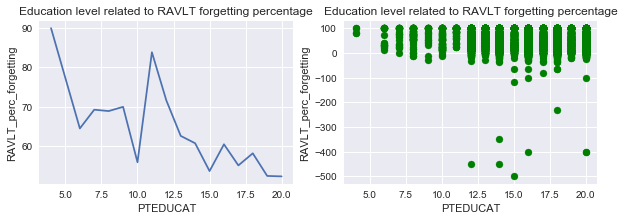

In [4]:
display(by_RID[['PTMARRY', 'RAVLT_perc_forgetting', 'FAQ', 'MMSE']].groupby(by='PTMARRY').agg(['mean','count']))

df = by_RID[['PTEDUCAT', 'RAVLT_perc_forgetting']].groupby(by='PTEDUCAT').agg(['mean'])
x = by_RID['PTEDUCAT'].unique()
x.sort()
y = df.get_values()[:,0]

fig, ax = plt.subplots(1,2,figsize = (10,3))

ax[0].plot(x,y)
ax[0].set_xlabel('PTEDUCAT')
ax[0].set_ylabel('RAVLT_perc_forgetting')
ax[0].set_title('Education level related to RAVLT forgetting percentage')

ax[1].scatter(by_RID['PTEDUCAT'], by_RID['RAVLT_perc_forgetting'], color='g')
ax[1].set_xlabel('PTEDUCAT')
ax[1].set_ylabel('RAVLT_perc_forgetting')
ax[1].set_title('Education level related to RAVLT forgetting percentage')
plt.show()

> Marriage seems to have an effect on RAVLT scores, and years of education has a clear relationship with the test as well. 

<br/> <br/>
#### 3. Do any individual tests directly correlate with the degeneration of a specific area of the brain?

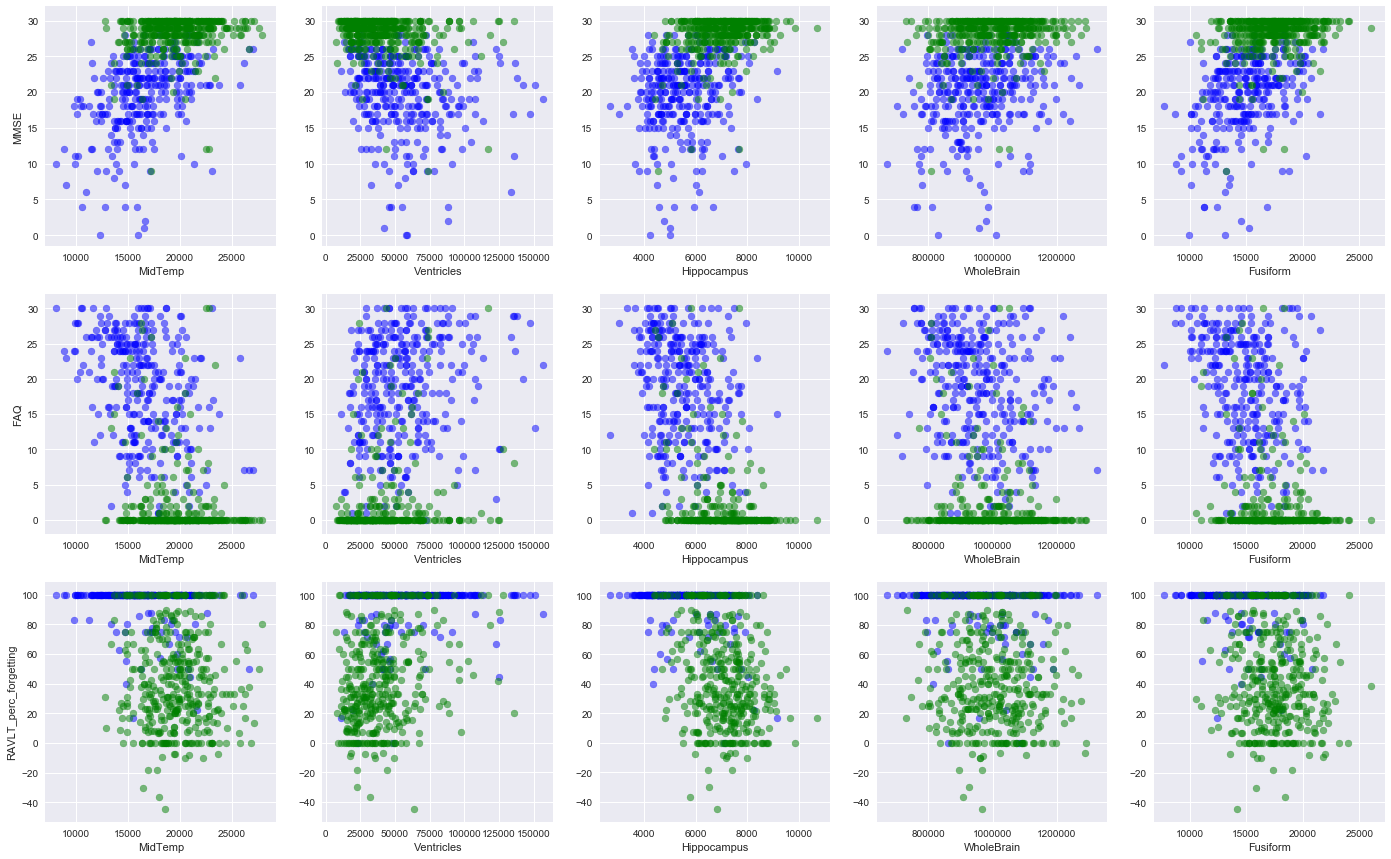

In [5]:
by_RID_again = data.sort_values(["RID","EXAMDATE"])
by_RID_again = by_RID_again.reset_index(drop=True)
last_exam = by_RID_again.groupby(by='RID').last()
brains = last_exam[last_exam.Ventricles.isnull() == False][['DX_bl','Ventricles', 'Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV','FAQ','RAVLT_perc_forgetting','MMSE']]

fig,ax = plt.subplots(3,5,figsize=(24,15))

#MMSE
ax[0,0].set_ylabel("MMSE")
ax[0,0].scatter(brains.MidTemp[brains.DX_bl == 'AD'],brains.MMSE[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[0,0].scatter(brains.MidTemp[brains.DX_bl == 'CN'],brains.MMSE[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[0,0].set_xlabel("MidTemp")

ax[0,1].scatter(brains.Ventricles[brains.DX_bl == 'AD'],brains.MMSE[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[0,1].scatter(brains.Ventricles[brains.DX_bl == 'CN'],brains.MMSE[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[0,1].set_xlabel("Ventricles")

ax[0,2].scatter(brains.Hippocampus[brains.DX_bl == 'AD'],brains.MMSE[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[0,2].scatter(brains.Hippocampus[brains.DX_bl == 'CN'],brains.MMSE[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[0,2].set_xlabel("Hippocampus")

ax[0,3].scatter(brains.WholeBrain[brains.DX_bl == 'AD'],brains.MMSE[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[0,3].scatter(brains.WholeBrain[brains.DX_bl == 'CN'],brains.MMSE[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[0,3].set_xlabel("WholeBrain")

ax[0,4].scatter(brains.Fusiform[brains.DX_bl == 'AD'],brains.MMSE[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[0,4].scatter(brains.Fusiform[brains.DX_bl == 'CN'],brains.MMSE[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[0,4].set_xlabel("Fusiform")

#FAQ
ax[1,0].set_ylabel("FAQ")
ax[1,0].scatter(brains.MidTemp[brains.DX_bl == 'AD'],brains.FAQ[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[1,0].scatter(brains.MidTemp[brains.DX_bl == 'CN'],brains.FAQ[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[1,0].set_xlabel("MidTemp")

ax[1,1].scatter(brains.Ventricles[brains.DX_bl == 'AD'],brains.FAQ[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[1,1].scatter(brains.Ventricles[brains.DX_bl == 'CN'],brains.FAQ[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[1,1].set_xlabel("Ventricles")

ax[1,2].scatter(brains.Hippocampus[brains.DX_bl == 'AD'],brains.FAQ[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[1,2].scatter(brains.Hippocampus[brains.DX_bl == 'CN'],brains.FAQ[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[1,2].set_xlabel("Hippocampus")

ax[1,3].scatter(brains.WholeBrain[brains.DX_bl == 'AD'],brains.FAQ[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[1,3].scatter(brains.WholeBrain[brains.DX_bl == 'CN'],brains.FAQ[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[1,3].set_xlabel("WholeBrain")

ax[1,4].scatter(brains.Fusiform[brains.DX_bl == 'AD'],brains.FAQ[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[1,4].scatter(brains.Fusiform[brains.DX_bl == 'CN'],brains.FAQ[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[1,4].set_xlabel("Fusiform")

#RAVLT_perc_forgetting
ax[2,0].set_ylabel("RAVLT_perc_forgetting")
ax[2,0].scatter(brains.MidTemp[brains.DX_bl == 'AD'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[2,0].scatter(brains.MidTemp[brains.DX_bl == 'CN'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[2,0].set_xlabel("MidTemp")

ax[2,1].scatter(brains.Ventricles[brains.DX_bl == 'AD'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[2,1].scatter(brains.Ventricles[brains.DX_bl == 'CN'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[2,1].set_xlabel("Ventricles")

ax[2,2].scatter(brains.Hippocampus[brains.DX_bl == 'AD'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[2,2].scatter(brains.Hippocampus[brains.DX_bl == 'CN'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[2,2].set_xlabel("Hippocampus")

ax[2,3].scatter(brains.WholeBrain[brains.DX_bl == 'AD'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[2,3].scatter(brains.WholeBrain[brains.DX_bl == 'CN'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[2,3].set_xlabel("WholeBrain")

ax[2,4].scatter(brains.Fusiform[brains.DX_bl == 'AD'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'AD'],color = "blue",alpha=.5)
ax[2,4].scatter(brains.Fusiform[brains.DX_bl == 'CN'],brains.RAVLT_perc_forgetting[brains.DX_bl == 'CN'],color = "green",alpha=.5)
ax[2,4].set_xlabel("Fusiform")

> It is clear that the degeneration of the Mid Temporal, Hippocampus, and Fusiform regions is correlated with scores on the MMSE, FAQ, and RAVLT cognitive tests. 
(Note: in the above charts, green data points are patients classified as ‘Cognitively Normal’, while blue points are patients classified as ‘Alzheimer’s Disease’.)

<br/> <br/>
#### 4. What are the general trends with the demographic data? 

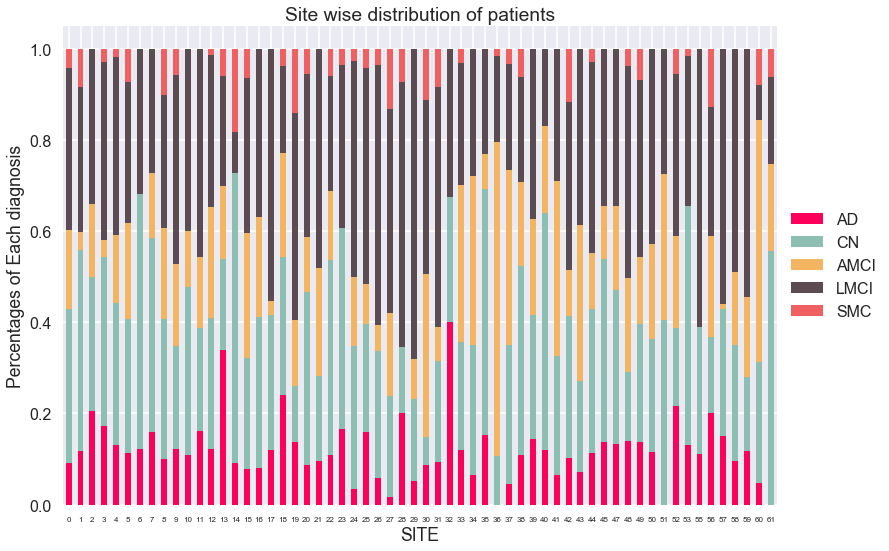

In [6]:
from sklearn import preprocessing
import seaborn as sns
sns.set_context('poster')

encode = preprocessing.LabelEncoder() 

df = pd.get_dummies(by_RID[['DX_bl']])
df['SITE'] = by_RID['SITE']
df2 = df.groupby(by=['SITE']).agg(['sum'])
x = encode.fit_transform(by_RID['SITE'].unique())
x.sort()
x = pd.DataFrame(x)
x=x.drop([46,54])


flatui = ["#FD0059", "#8CBEB2", "#F3B562", "#5C4B51", "#F06060" ]
sns.set_palette(flatui)

# Generating percentages
b = pd.DataFrame(df2.get_values())
s = b.sum(axis=1)

c=pd.DataFrame()
for col in b.columns:
    c[col] = b[col]/s
c=c.drop([46,54])

c=c.rename(index=str, columns={0: "AD", 1: "CN", 2:"AMCI", 3:"LMCI", 4:"SMC"})
c.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(fontsize=8, rotation=0)
plt.xlabel('SITE')
plt.ylabel('Percentages of Each diagnosis')
plt.title('Site wise distribution of patients')
plt.show()


<br/> <br/>
#### 5. Since the data is longitudinal, what scores actually change over time and different tests?

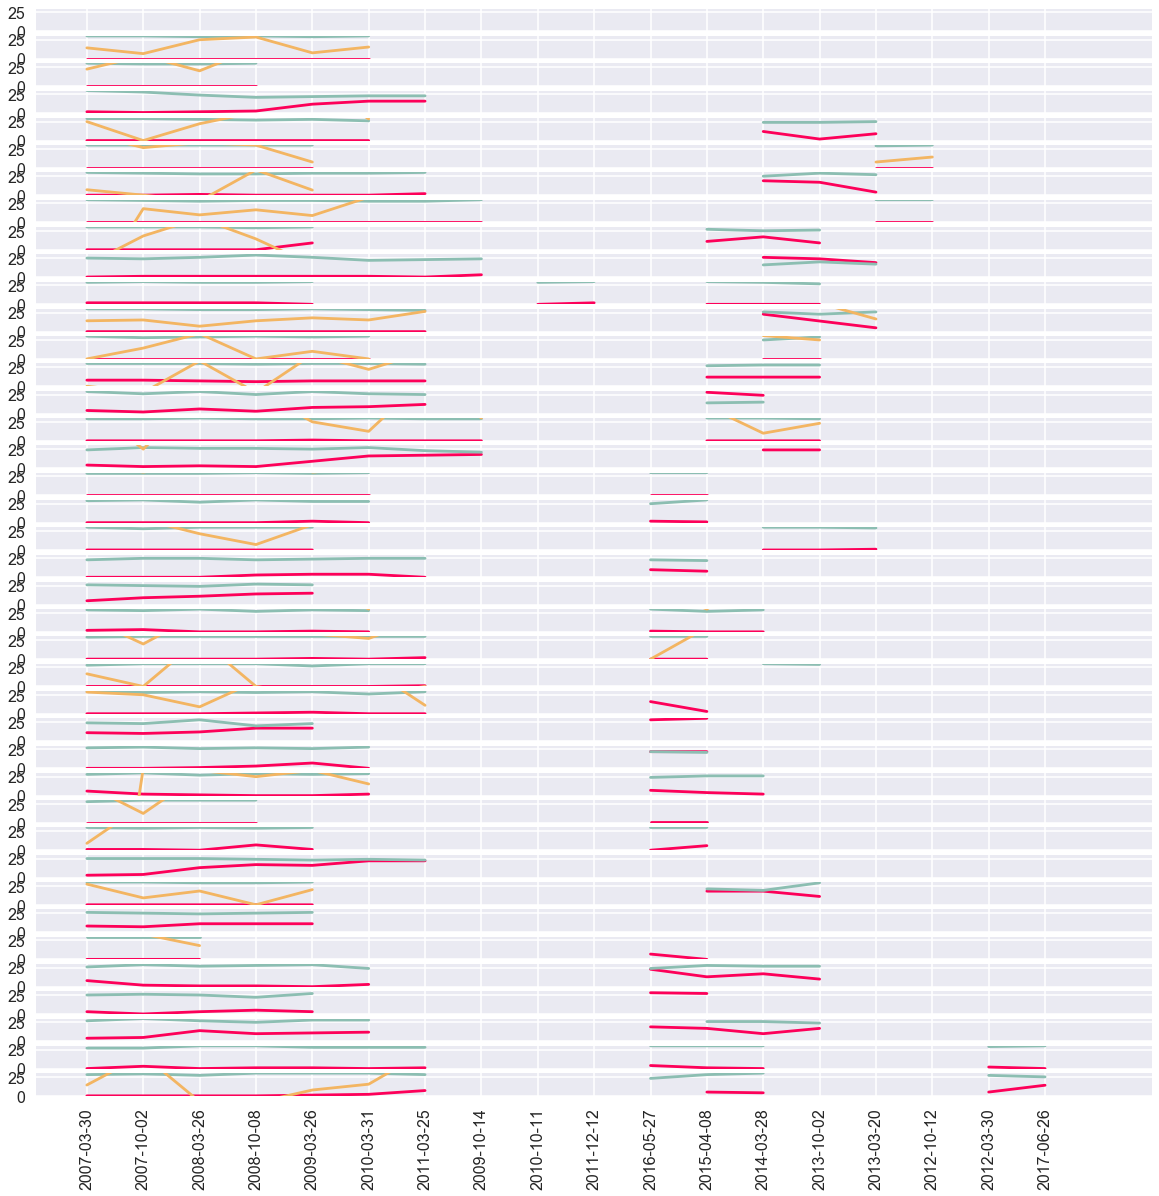

In [7]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

interesting_cols_again = ['RID','EXAMDATE', 'MMSE', 'RAVLT_perc_forgetting', 'FAQ']
subset_1 = data[interesting_cols_again].copy()
subset_1.EXAMDATE = pd.to_datetime(subset_1.EXAMDATE)
subset_1['EXAMDATE'] = subset_1['EXAMDATE'].map(lambda x:x.date())

count_test = subset_1.groupby("RID", as_index= False)["EXAMDATE"].count()
count_test = count_test.rename(columns = {"EXAMDATE" : "count"})
count_test[count_test["count"]>17]

first_test = subset_1.groupby("RID", as_index=False)["EXAMDATE"].min()
first_test = first_test.rename(columns = {"EXAMDATE" : "first_test"})
MMSE_diff = subset_1.groupby("RID", as_index=True)["MMSE"].max() - subset_1.groupby("RID", as_index=True)["MMSE"].min()
RAVLT_diff = subset_1.groupby("RID", as_index=False)["RAVLT_perc_forgetting"].max() - subset_1.groupby("RID", as_index=False)["RAVLT_perc_forgetting"].min()
FAQ_diff = subset_1.groupby("RID", as_index=False)["FAQ"].max() - subset_1.groupby("RID", as_index=False)["FAQ"].min()
last_test = subset_1.groupby("RID", as_index= False)["EXAMDATE"].max()
last_test = last_test.rename(columns = {"EXAMDATE" : "last_test"})
count_test = subset_1.groupby("RID", as_index= False)["EXAMDATE"].count()
count_test = count_test.rename(columns = {"EXAMDATE" : "count"})
test_time_df = pd.merge(first_test,last_test)
test_time_df = pd.merge(test_time_df, count_test)

test_time_df["Diff_month"] = (test_time_df.last_test - test_time_df.first_test)/ np.timedelta64(1, 'M')


fig, axes = plt.subplots(40,1,figsize=(20, 20), sharey= True, sharex=True)
i = 0
cdict = {'red':   [(0.0, 1.0, 1.0),  # red decreases
                   (1.0, 0.0, 0.0)],

         'green': [(0.0, 0.0, 0.0),  # green increases
                   (1.0, 1.0, 1.0)],

         'blue':  [(0.0, 0.0, 0.0),  # no blue at all
                   (1.0, 0.0, 0.0)]}

red_green_cm = LinearSegmentedColormap('GreenBlue', cdict,40)
colors = cm.get_cmap(red_green_cm, 40)
for rid in test_time_df.RID[test_time_df["count"]>17]:
    for pat, df_patient in data.groupby('RID'):
        if(rid == df_patient.RID.unique()[0]):
            #print(i)
            i = i+1
            #print(range(len(df_patient.EXAMDATE.values)))
            axes[i].plot(range(len(df_patient.EXAMDATE.values)), df_patient.FAQ)
            axes[i].plot(range(len(df_patient.EXAMDATE.values)), df_patient.MMSE)
            axes[i].plot(range(len(df_patient.EXAMDATE.values)), df_patient.RAVLT_perc_forgetting)
            axes[i].set_ylim(0,30)
            plt.xticks(range(len(df_patient.EXAMDATE.values)), df_patient.EXAMDATE.values, rotation='vertical')